# Import

In [1]:
import mmdet
import mmcv
import mmengine
from mmengine import Config
from mmengine.runner import set_random_seed
#from mmdet.datasets import build_dataset
#from mmdet.models import build_detector
from mmengine.runner import Runner
from mmdet.apis import init_detector, inference_detector
from mmengine.visualization import Visualizer

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import json

import warnings
warnings.filterwarnings('ignore') #Ignore "future" warnings and Data-Frame-Slicing warnings.

from sklearn.model_selection import KFold, StratifiedKFold
from pytorch_lightning import seed_everything

# Config

In [3]:
class CFG:
    class general:
        #project_name = "HuBMAP2023"
        input_path = "../data/input"
        output_path = "../data/output"
        save_name = "exp22_mask2former_10000"
        seed = 0
        cv = True
        #wandb_desabled = True
        n_splits = 5
        fold = [0] # list (0-idx start) or null. Set one element list, hold-out mode.

# Utils

In [4]:
"""
def wandb_start(cfg):
    wandb.init(
        project=cfg["general"]["project_name"],
        name=f"{cfg['general']['save_name']}_{cfg['fold_n']}",
        group=f"{cfg['general']['save_name']}_cv" if cfg["general"]["cv"] else "all",
        job_type=cfg["job_type"],
        mode="disabled" if cfg["general"]["wandb_desabled"] else "online",
        config=cfg,
    )
"""

'\ndef wandb_start(cfg):\n    wandb.init(\n        project=cfg["general"]["project_name"],\n        name=f"{cfg[\'general\'][\'save_name\']}_{cfg[\'fold_n\']}",\n        group=f"{cfg[\'general\'][\'save_name\']}_cv" if cfg["general"]["cv"] else "all",\n        job_type=cfg["job_type"],\n        mode="disabled" if cfg["general"]["wandb_desabled"] else "online",\n        config=cfg,\n    )\n'

# Main

### Read data

In [5]:
tile_meta = pd.read_csv(f"{CFG.general.input_path}/tile_meta.csv")
polygons = pd.read_json(f"{CFG.general.input_path}/polygons.jsonl", lines=True)
train = pd.merge(polygons, tile_meta, on="id", how="left")
print(len(train))

1633


In [ ]:
valid_cv = train[(train["source_wsi"]==1) & (train["dataset"]==1)].reset_index(drop=True)
train_cv = train[(train["source_wsi"]!=1)].reset_index(drop=True)

In [ ]:
with open(f"{CFG.general.input_path}/coco_annotations_all.json") as f:
    coco_json = json.load(f)

In [ ]:
coco_info = pd.DataFrame(coco_json["info"])
coco_licenses = pd.DataFrame(coco_json["licenses"])
coco_categories = pd.DataFrame(coco_json["categories"])
coco_images = pd.DataFrame(coco_json["images"])
coco_annotations = pd.DataFrame(coco_json["annotations"])

In [11]:
if CFG.general.cv:
    for fold_n in CFG.general.fold:
        coco_images_valid = coco_images[coco_images["id"].isin(valid_cv["id"])].reset_index(drop=True)
        
        coco_annotations_valid = coco_annotations[coco_annotations["image_id"].isin(valid_cv["id"])].reset_index(drop=True)
        
        # bloodだけにするかどうか
        coco_annotations_valid = coco_annotations_valid[coco_annotations_valid["category_id"]==2].reset_index(drop=True)
        
        # unsureを除くかどうか
        #coco_annotations_valid = coco_annotations_valid[coco_annotations_valid["category_id"]!=3].reset_index(drop=True)
        
        # glomerulusを除くかどうか
        coco_annotations_train = coco_annotations_train[coco_annotations_train["category_id"]!=1].reset_index(drop=True)
        #coco_annotations_valid = coco_annotations_valid[coco_annotations_valid["category_id"]!=1].reset_index(drop=True)        
        
        # unsureをbloodにするかどうか
        coco_annotations_train.loc[coco_annotations_train["category_id"]==3, "category_id"] = 2
        #coco_annotations_valid.loc[coco_annotations_valid["category_id"]==3, "category_id"] = 2
        
        coco_annotations_train["id"] = coco_annotations_train.index + 1
        coco_annotations_valid["id"] = coco_annotations_valid.index + 1

        coco_json_train = coco_json.copy()
        coco_json_valid = coco_json.copy()

        coco_json_train["categories"] = [coco_categories.iloc[1].to_dict()]
        coco_json_valid["categories"] = [coco_categories.iloc[1].to_dict()]
        #coco_json_train["categories"] = coco_categories.iloc[:2].to_dict(orient="records")
        #coco_json_valid["categories"] = coco_categories.iloc[:2].to_dict(orient="records")
        
        coco_json_train["images"] = coco_images_train.to_dict(orient="records")
        coco_json_train["annotations"] = coco_annotations_train.to_dict(orient="records")
        coco_json_valid["images"] = coco_images_valid.to_dict(orient="records")
        coco_json_valid["annotations"] = coco_annotations_valid.to_dict(orient="records")

        output_file_path = f"{CFG.general.input_path}/coco_annotations_train_fold{fold_n}.json"
        with open(output_file_path, "w", encoding="utf-8") as output_file:
            json.dump(coco_json_train, output_file, ensure_ascii=True, indent=4)

        output_file_path = f"{CFG.general.input_path}/coco_annotations_valid_fold{fold_n}.json"
        with open(output_file_path, "w", encoding="utf-8") as output_file:
            json.dump(coco_json_valid, output_file, ensure_ascii=True, indent=4)
            
        print(f"train annos: {len(coco_annotations_train)}, images: {len(coco_images_train)}")
        print(f"valid annos: {len(coco_annotations_valid)}, images: {len(coco_images_valid)}")
else:
    pass
    """
    print(f"fold all: create json")
    coco_annotations_train = coco_annotations_train[coco_annotations_train["category_id"]==2].reset_index(drop=True)
    coco_annotations_valid = coco_annotations_valid[coco_annotations_valid["category_id"]==2].reset_index(drop=True)
    coco_annotations_train["id"] = coco_annotations_train.index + 1
    coco_annotations_valid["id"] = coco_annotations_valid.index + 1
    
    coco_json_train = coco_json.copy()
    coco_json_valid = coco_json.copy()
    
    coco_json_train["categories"] = [coco_categories.iloc[1].to_dict()]
    coco_json_train["images"] = coco_images_train.to_dict(orient="records")
    coco_json_train["annotations"] = coco_annotations_train.to_dict(orient="records")
    coco_json_valid["categories"] = [coco_categories.iloc[1].to_dict()]
    coco_json_valid["images"] = coco_images_valid.to_dict(orient="records")
    coco_json_valid["annotations"] = coco_annotations_valid.to_dict(orient="records")
    
    output_file_path = f"coco_annotations_train_fold_all.json"
    with open(output_file_path, "w", encoding="utf-8") as output_file:
        json.dump(coco_json_train, output_file, ensure_ascii=True, indent=4)

    output_file_path = f"coco_annotations_valid_fold_all.json"
    with open(output_file_path, "w", encoding="utf-8") as output_file:
        json.dump(coco_json_valid, output_file, ensure_ascii=True, indent=4)
    """

fold0: create json
train annos: 15410, images: 1548
valid annos: 644, images: 85


In [16]:
cfg = Config.fromfile("/notebooks/data/output/exp18_convnext_640-1536/cascade-mask-rcnn_convnext-t-p4-w7_fpn_4conv1fc-giou_amp-ms-crop-3x_coco.py")
cfg.model.test_cfg.rcnn.score_thr = 0.0
cfg.load_from = "/notebooks/data/output/exp18_convnext_640-1536/epoch_1.pth"

runner = Runner.from_cfg(cfg)
runner.test()

07/10 12:06:02 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.9.16 (main, Dec  7 2022, 01:11:51) [GCC 9.4.0]
    CUDA available: True
    numpy_random_seed: 882494840
    GPU 0: NVIDIA RTX A6000
    CUDA_HOME: /usr/local/cuda-11.6
    NVCC: Cuda compilation tools, release 11.6, V11.6.124
    GCC: x86_64-linux-gnu-gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 1.12.1+cu116
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.6
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=co

{'coco/segm_mAP': 0.459,
 'coco/segm_mAP_50': 0.784,
 'coco/segm_mAP_75': 0.502,
 'coco/segm_mAP_s': 0.376,
 'coco/segm_mAP_m': 0.523,
 'coco/segm_mAP_l': 0.697}

In [5]:
cfg = Config.fromfile("/notebooks/data/output/pseudo_fold/exp101_convnext_validchange_pseudo05_ens/cascade-mask-rcnn_convnext-t-p4-w7_fpn_4conv1fc-giou_amp-ms-crop-3x_coco.py")
#cfg.model.test_cfg.rcnn.score_thr = 0.05
cfg.load_from = "/notebooks/data/output/pseudo_fold/exp101_convnext_validchange_pseudo05_ens/epoch_1.pth"

runner = Runner.from_cfg(cfg)
runner.valid()

07/26 15:16:16 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.9.16 (main, Dec  7 2022, 01:11:51) [GCC 9.4.0]
    CUDA available: True
    numpy_random_seed: 893927282
    GPU 0: NVIDIA RTX A6000
    CUDA_HOME: /usr/local/cuda-11.6
    NVCC: Cuda compilation tools, release 11.6, V11.6.124
    GCC: x86_64-linux-gnu-gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 1.12.1+cu116
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.6
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=co

AttributeError: 'Runner' object has no attribute 'valid'

In [6]:
cfg = Config.fromfile("/notebooks/data/output/pseudo_fold/exp101_convnext_validchange_pseudo05_ens/cascade-mask-rcnn_convnext-t-p4-w7_fpn_4conv1fc-giou_amp-ms-crop-3x_coco.py")
cfg.model.test_cfg.rcnn.score_thr = 0.05
cfg.load_from = "/notebooks/data/output/pseudo_fold/exp101_convnext_validchange_pseudo05_ens/epoch_1.pth"

runner = Runner.from_cfg(cfg)
runner.test()

07/26 15:06:14 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.9.16 (main, Dec  7 2022, 01:11:51) [GCC 9.4.0]
    CUDA available: True
    numpy_random_seed: 1799977106
    GPU 0: NVIDIA RTX A6000
    CUDA_HOME: /usr/local/cuda-11.6
    NVCC: Cuda compilation tools, release 11.6, V11.6.124
    GCC: x86_64-linux-gnu-gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 1.12.1+cu116
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.6
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=c

{'coco/segm_mAP': 0.271,
 'coco/segm_mAP_50': 0.535,
 'coco/segm_mAP_75': 0.266,
 'coco/segm_mAP_s': 0.08,
 'coco/segm_mAP_m': 0.325,
 'coco/segm_mAP_l': 0.359}

In [6]:
#0.288
#CFG.general.save_name = "exp18_convnext_640-1536"
cfg = Config.fromfile(f"/notebooks/data/output/convnext_fold_pseudo2_095_lr-6/cascade-mask-rcnn_convnext-t-p4-w7_fpn_4conv1fc-giou_amp-ms-crop-3x_coco.py")

runs = []
for size in [640, 768, 896, 1024, 1152, 1280, 1408, 1536]:
    print(f"[{size}]")
    cfg.load_from = f"/notebooks/data/output/convnext_fold_pseudo2_095_lr-6/epoch_1.pth"
    cfg.model.test_cfg.rcnn.score_thr = 0
    cfg.test_pipeline = [
            dict(type="LoadImageFromFile", backend_args=None),
            dict(type="Resize", scale=(size, size), keep_ratio=True),
            dict(type="LoadAnnotations", with_bbox=True, with_mask=True),
            dict(
                type="PackDetInputs",
                meta_keys=("img_id", "img_path", "ori_shape", "img_shape", "scale_factor"))
        ]
    cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
    runner = Runner.from_cfg(cfg)
    runs.append(runner)

[640]
07/31 10:27:18 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.9.16 (main, Dec  7 2022, 01:11:51) [GCC 9.4.0]
    CUDA available: True
    numpy_random_seed: 1910071232
    GPU 0: NVIDIA RTX A6000
    CUDA_HOME: /usr/local/cuda-11.6
    NVCC: Cuda compilation tools, release 11.6, V11.6.124
    GCC: x86_64-linux-gnu-gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 1.12.1+cu116
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.6
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;

In [7]:
for run_, thr in zip(runs, [640, 768, 896, 1024, 1152, 1280, 1408, 1536]):
    print(f"[{thr}]")
    run_.val()

[640]
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loads checkpoint by local backend from path: /notebooks/data/output/convnext_fold_pseudo2_095_lr-6/epoch_1.pth
07/31 10:27:44 - mmengine - INFO - Load checkpoint from /notebooks/data/output/convnext_fold_pseudo2_095_lr-6/epoch_1.pth
07/31 10:28:07 - mmengine - INFO - Iter(val) [100/270]    eta: 0:00:38  time: 0.1821  data_time: 0.0110  memory: 2981  
07/31 10:28:26 - mmengine - INFO - Iter(val) [200/270]    eta: 0:00:14  time: 0.1927  data_time: 0.0124  memory: 2981  
07/31 10:28:40 - mmengine - INFO - Evaluating segm...
Loading and preparing results...
DONE (t=0.15s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=1.93s).
Accumulating evaluation results...
DONE (t=0.45s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.341
 Average 

In [22]:
cfg.load_from = f"{CFG.general.output_path}/{CFG.general.save_name}/epoch_1.pth"
cfg.test_pipeline = [
        dict(type="LoadImageFromFile", backend_args=None),
        dict(type="Resize", scale=(1024, 1024), keep_ratio=True),
        dict(type="LoadAnnotations", with_bbox=True, with_mask=True),
        dict(
            type="PackDetInputs",
            meta_keys=("img_id", "img_path", "ori_shape", "img_shape", "scale_factor"))
    ]
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
runner = Runner.from_cfg(cfg)
runs.append(runner)

07/04 04:25:33 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.9.16 (main, Dec  7 2022, 01:11:51) [GCC 9.4.0]
    CUDA available: True
    numpy_random_seed: 1006747939
    GPU 0: NVIDIA RTX A6000
    CUDA_HOME: /usr/local/cuda-11.6
    NVCC: Cuda compilation tools, release 11.6, V11.6.124
    GCC: x86_64-linux-gnu-gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 1.12.1+cu116
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.6
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=c

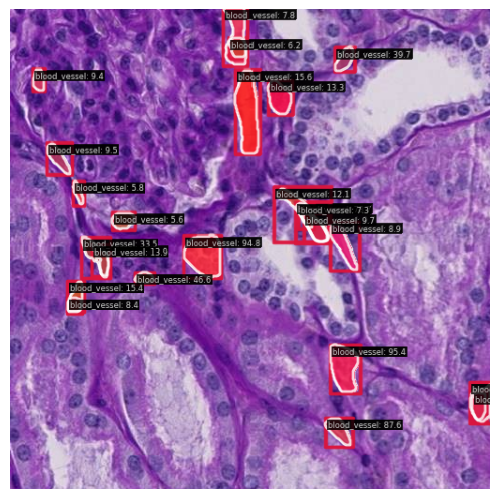

In [23]:
# get built visualizer
visualizer_now = Visualizer.get_current_instance()
# the dataset_meta is loaded from the checkpoint and
# then pass to the model in init_detector
visualizer_now.dataset_meta = model.dataset_meta
# show the results
visualizer_now.add_datasample(
    "new_result",
    img,
    data_sample=new_result,
    draw_gt=False,
    wait_time=0,
    out_file=None,
    pred_score_thr=0.0
)
visualizer_now.show()